In [24]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.dates as mdates
import torch.nn.functional as F
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error, r2_score
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
Data=pd.read_excel("QBO Data.xlsx")
columns_name = ['25 hPa']
data = pd.DataFrame(Data, columns=columns_name)
# time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

In [3]:
data.head()

,25 hPa
0,-289
1,-280
2,-309
3,-303
4,-289


In [4]:
data.shape

(419, 1)

In [5]:
data.columns

Index(['25 hPa'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   25 hPa  419 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=28).mean()
    MSTD = timeseries.rolling(window=28).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

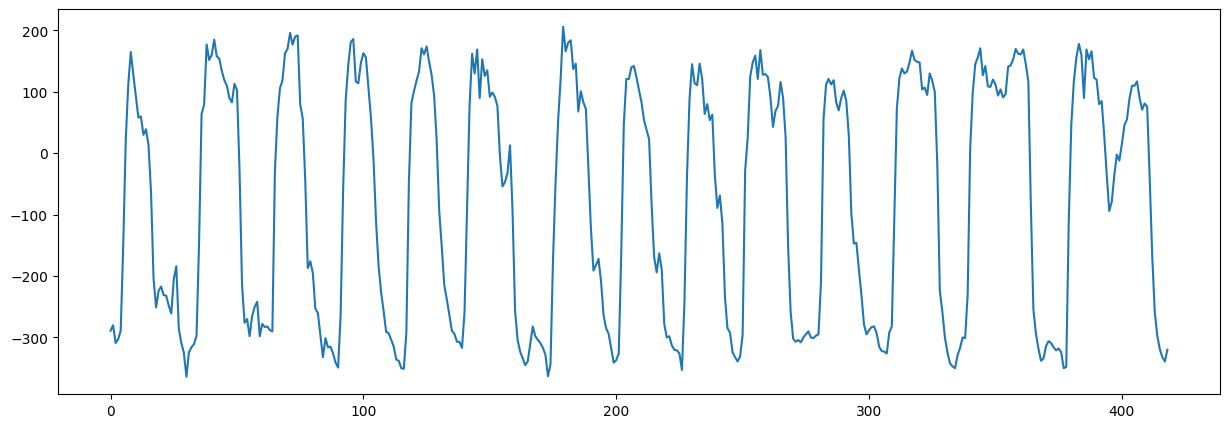

In [9]:
plt.figure(figsize = (15,5))
data['25 hPa'].plot();

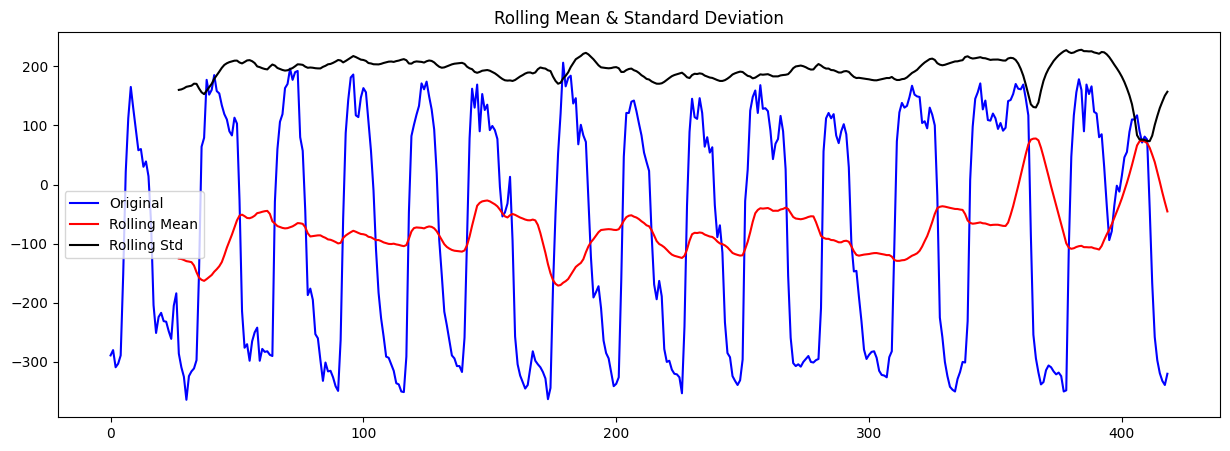

Results of Dickey-Fuller Test:
Test Statistic                -8.942076e+00
p-value                        9.195652e-15
#Lags Used                     1.100000e+01
Number of Observations Used    4.070000e+02
Critical Value (1%)           -3.446520e+00
Critical Value (5%)           -2.868668e+00
Critical Value (10%)          -2.570567e+00
dtype: float64


In [10]:
test_stationarity(data['25 hPa'])

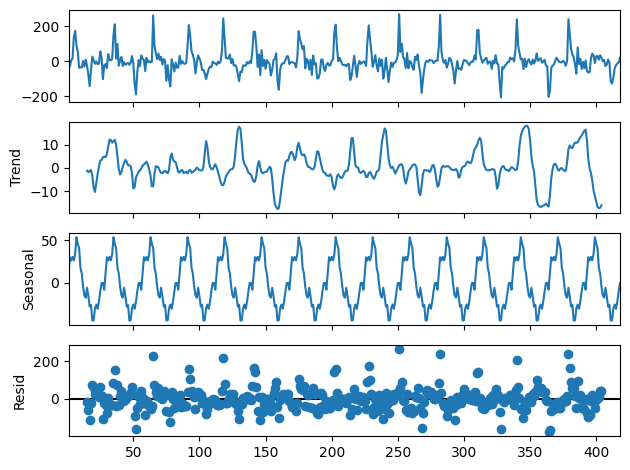

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 28).plot()
plt.show()

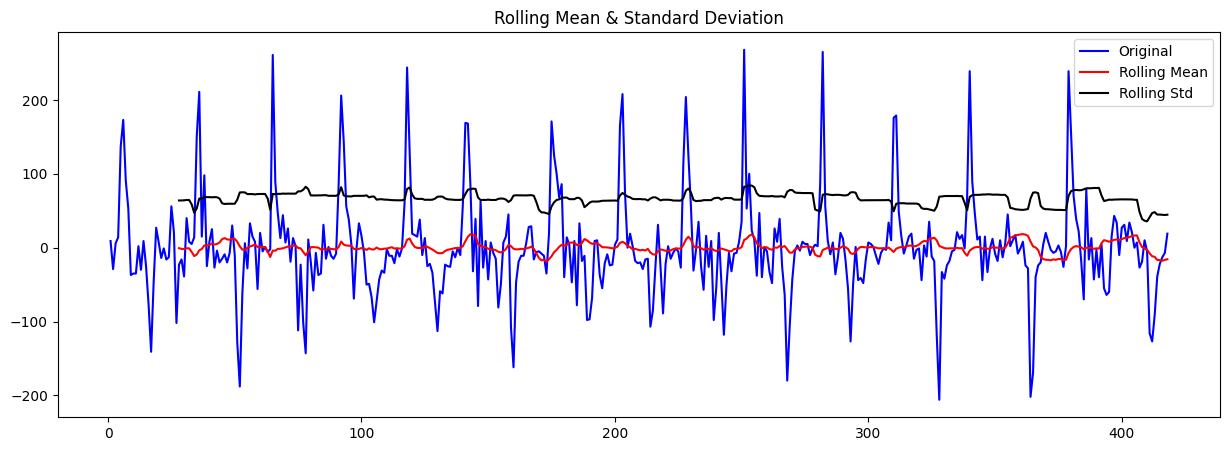

Results of Dickey-Fuller Test:
Test Statistic                -9.116292e+00
p-value                        3.295583e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [12]:
test_stationarity(data_diff)

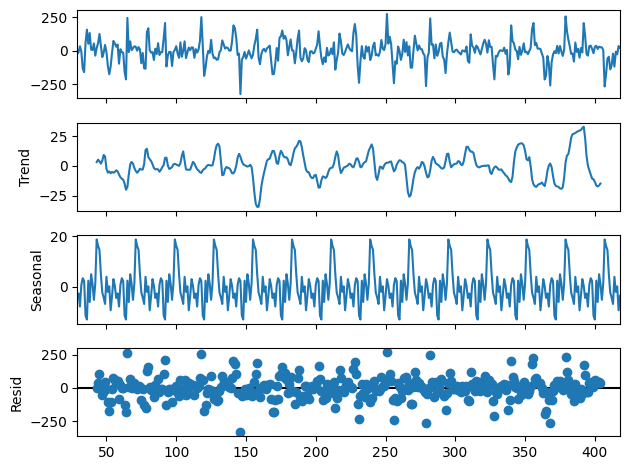

In [13]:
data_diff_seas = data_diff.diff(28)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 28)
dec.plot()
plt.show()

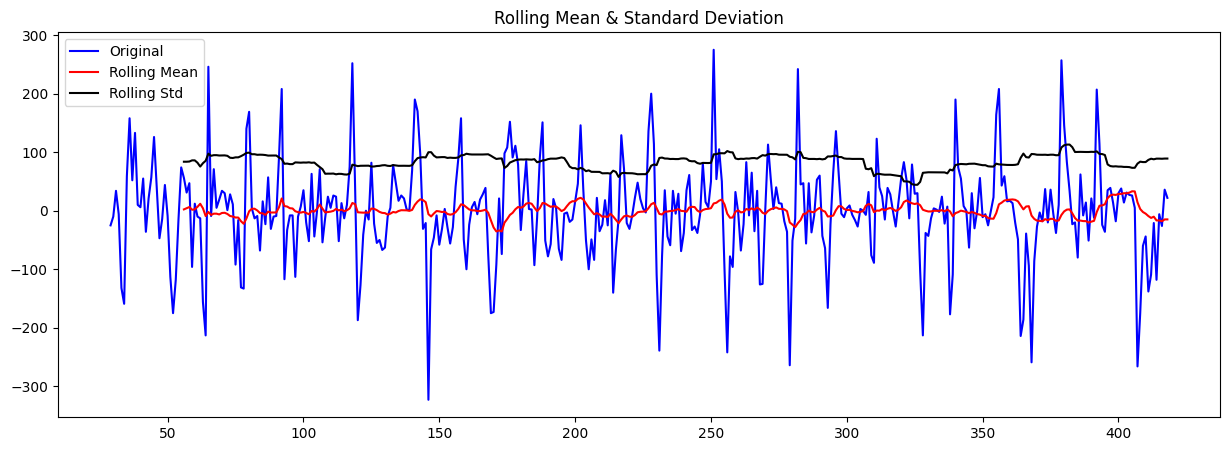

Results of Dickey-Fuller Test:
Test Statistic                -1.174556e+01
p-value                        1.243920e-21
#Lags Used                     2.000000e+00
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [14]:
test_stationarity(data_diff_seas['25 hPa'])

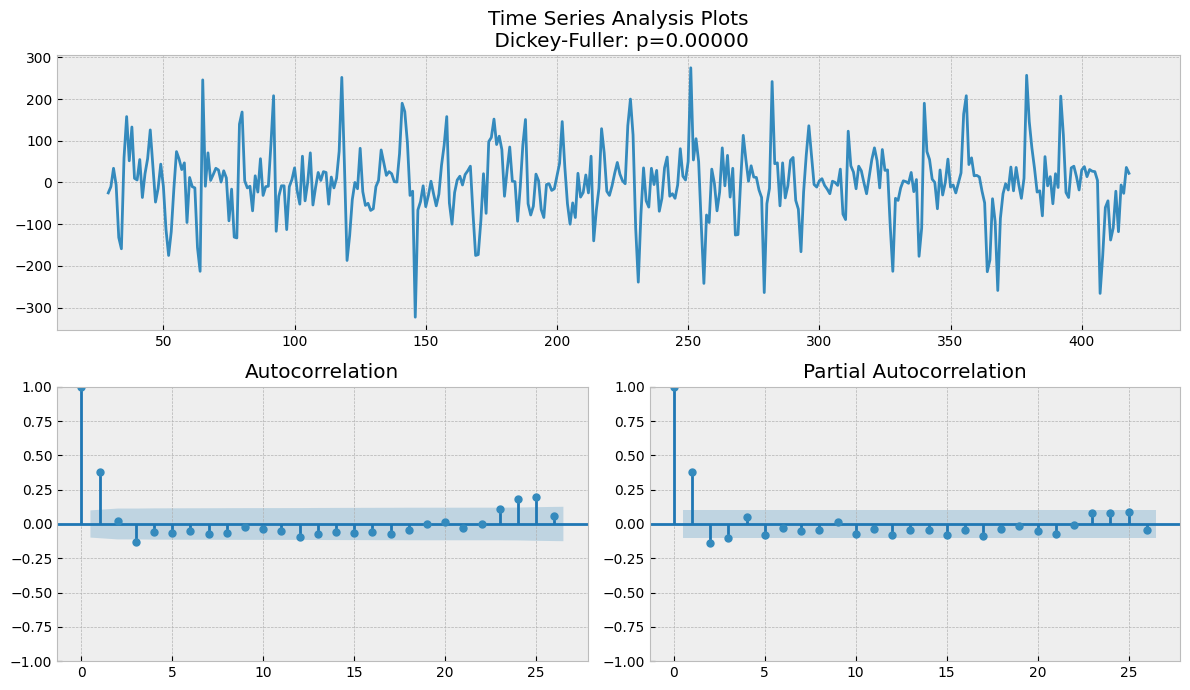

In [15]:
tsplot(data_diff_seas['25 hPa'])

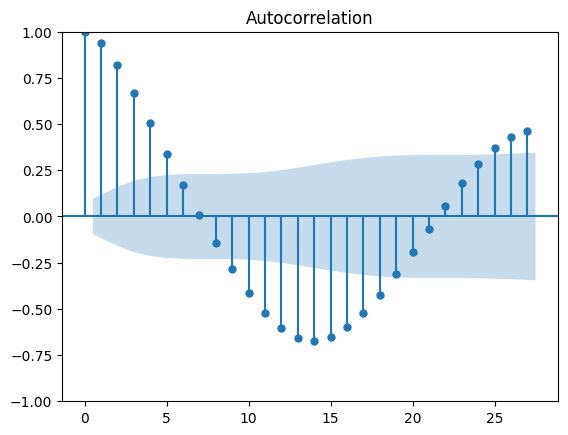

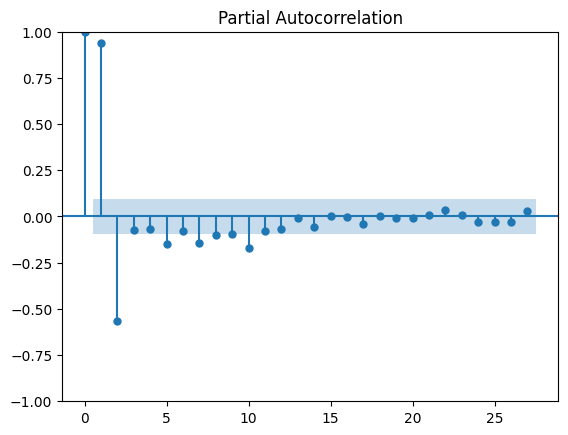

In [18]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
model = pm.auto_arima(data, seasonal=False, stepwise=True, trace=True)

# Ringkasan model
print(model.summary())
# Menampilkan parameter terbaik yang ditemukan
best_order = model.order  # Parameter p, d, q terbaik
print(f"Best ARIMA model order (p, d, q): {best_order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4510.994, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5668.005, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4690.366, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5197.011, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4534.025, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4519.179, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4523.031, Time=1.61 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4508.651, Time=1.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4531.858, Time=0.27 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4508.906, Time=0.84 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=4508.529, Time=0.37 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4527.391, Time=0.32 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=4497.168, Time=1.03 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=4499.808, Time=1.07 sec
 ARIMA(3,0,5)(0,0,0)[0]          

In [17]:
import pandas as pd
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 1. Definisikan Parameter (lebih sempit)
# ===============================
# Rentang sempit tapi masih fleksibel
p = d = q = range(0, 3)  # ARIMA (p,d,q): 0–2
P = D = Q = range(0, 2)  # Seasonal (P,D,Q): 0–1
m = 28                   # Periode musiman (QBO 28 bulan)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# ===============================
# 2. Grid Search SARIMA
# ===============================
results = []
total_combinations = len(pdq) * len(seasonal_pdq)
print(f"Evaluating {total_combinations} combinations...")

for param in tqdm(pdq, desc="Outer Loop"):
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(data,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic

            # Simpan hasil
            results.append({
                'order': param,
                'seasonal_order': seasonal_param,
                'AIC': aic
            })

        except Exception as e:
            # Jika error, lanjut saja
            continue

# ===============================
# 3. Tampilkan Hasil Terbaik
# ===============================
if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

    print("\n✅ Model SARIMA terbaik berdasarkan AIC:")
    print(results_df.head(1))

    print("\n📊 Top 5 model terbaik:")
    print(results_df.head(5))
else:
    print("❌ Tidak ada model yang berhasil di-fit. Coba ubah rentang parameter atau periksa data.")

Evaluating 216 combinations...


Outer Loop: 100%|██████████| 27/27 [15:17<00:00, 33.98s/it]


✅ Model SARIMA terbaik berdasarkan AIC:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828

📊 Top 5 model terbaik:
       order seasonal_order          AIC
0  (2, 0, 2)  (0, 1, 1, 28)  3916.555828
1  (2, 0, 2)  (1, 1, 1, 28)  3918.224360
2  (1, 0, 2)  (0, 1, 1, 28)  3935.425782
3  (2, 1, 1)  (0, 1, 1, 28)  3936.966636
4  (1, 0, 2)  (1, 1, 1, 28)  3937.425700


In [19]:
# Fit model SARIMA terbaik
model = SARIMAX(data,
                order=(2, 0, 2),
                seasonal_order=(0, 1, 1, 28),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()

# Ringkasan model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               25 hPa   No. Observations:                  419
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 28)   Log Likelihood               -1952.278
Date:                              Fri, 30 May 2025   AIC                           3916.556
Time:                                      13:50:08   BIC                           3939.872
Sample:                                           0   HQIC                          3925.827
                                              - 419                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8550      0.027     68.528      0.000       1.802       1.908
ar.L2         -0.89

In [20]:
# Split data menjadi data latih dan data uji 80:20
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [21]:
train_pred = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)  # Prediksi untuk data uji

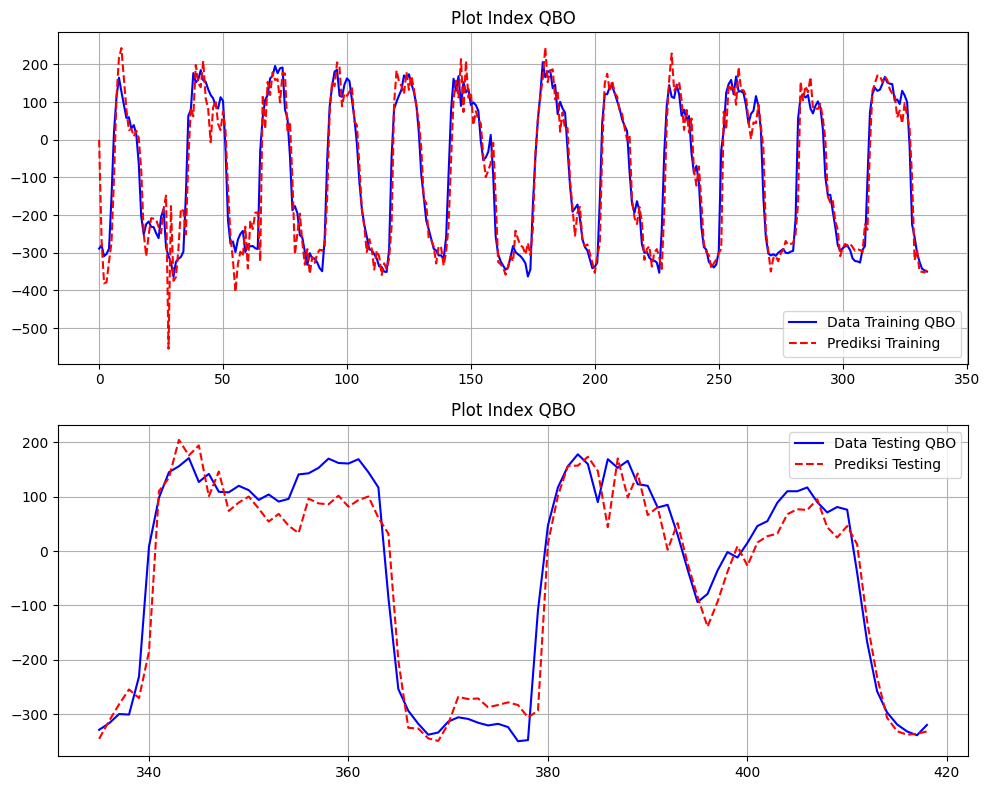

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  

# Plot pertama
axs[0].plot(train.index, train, label='Data Training QBO', color='blue')
axs[0].plot(train.index, train_pred, label="Prediksi Training", color='red', linestyle='--')
axs[0].set_title('Plot Index QBO')
axs[0].legend()
axs[0].grid(True)

# Plot kedua
axs[1].plot(test.index, test, label='Data Testing QBO', color='blue')
axs[1].plot(test.index, test_pred, label="Prediksi Testing", color='red', linestyle='--')
axs[1].set_title('Plot Index QBO')
axs[1].legend()
axs[1].grid(True)


# Menambahkan jarak antara subplot
plt.tight_layout()

# Menampilkan plot
plt.show()

In [25]:
# MSE (Mean Squared Error)                          % Data Training
mse_train = mean_squared_error(train, train_pred)
# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(train, train_pred)
# R2 (Coefficient of Determination)
r2_train = r2_score(train, train_pred)

# MSE (Mean Squared Error)                          % Data Testing
mse_test = mean_squared_error(test, test_pred)
# RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mse_test)
# MAE (Mean Absolute Error)
mae_test = mean_absolute_error(test, test_pred)
# R2 (Coefficient of Determination)
r2_test = r2_score(test, test_pred)

# Display metrics in a DataFrame
metrics_data = {
    'Metric': ['R\N{SUPERSCRIPT TWO}', 'MAE', 'MSE', 'RMSE'],
    'Train Data': [r2_train, mae_train, mse_train, rmse_train],
    'Test Data': [r2_test, mae_test, mse_test, rmse_test]}

metrics_qbo = pd.DataFrame(metrics_data)
metrics_qbo = metrics_qbo.round(4)

print(metrics_qbo)

  Metric  Train Data  Test Data
0     R²      0.8967     0.9236
1    MAE     43.3785    40.6354
2    MSE   3836.2203  2852.4884
3   RMSE     61.9372    53.4087


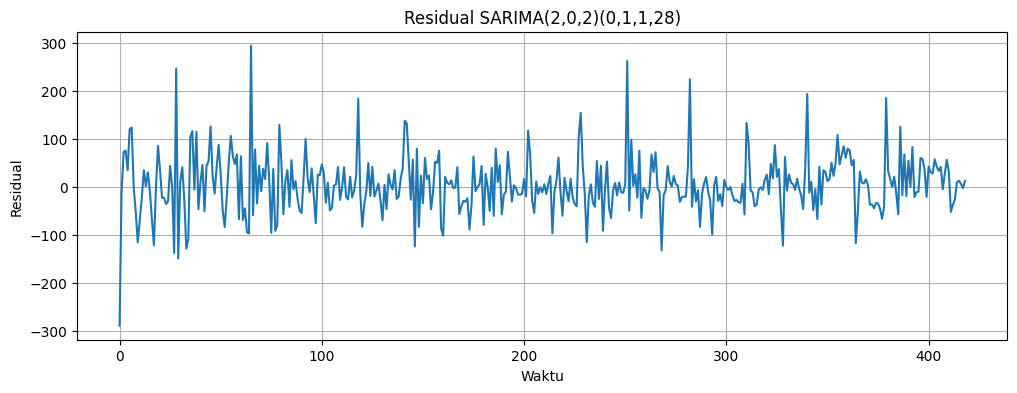

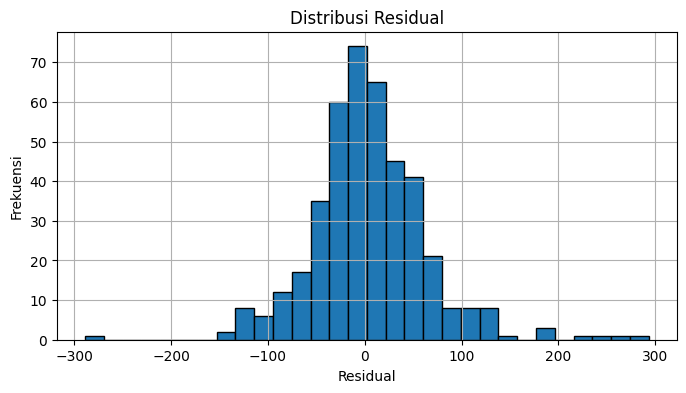

<Figure size 800x400 with 0 Axes>

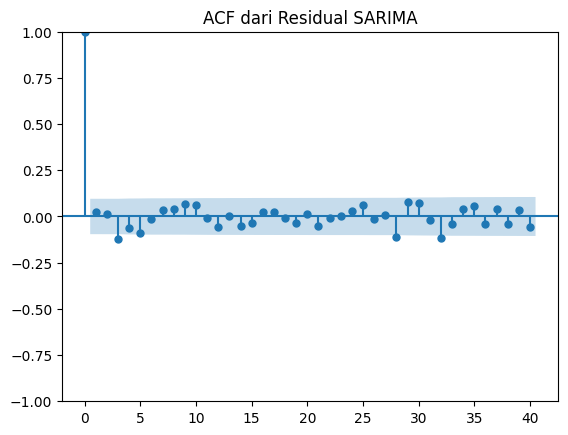

ADF Statistic: -13.019079486870526
P-Value: 2.475483904192821e-24
✅ Residual bersifat stasioner (white noise).


In [26]:
# ===== Analisis Residual =====
residuals = model_fit.resid

# Plot residual
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residual SARIMA(2,0,2)(0,1,1,28)")
plt.xlabel("Waktu")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# Histogram residual
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribusi Residual")
plt.xlabel("Residual")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

# ACF dari residual
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=40)
plt.title("ACF dari Residual SARIMA")
plt.show()

# Uji ADF
adf_stat, p_value, _, _, _, _ = adfuller(residuals)
print(f"ADF Statistic: {adf_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("✅ Residual bersifat stasioner (white noise).")
else:
    print("⚠️ Residual tidak stasioner. Model bisa ditingkatkan.")